In [152]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set_style('darkgrid')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 20)

In [153]:
raw_df = pd.read_csv('../shared_datasets/survey_results_public.csv')

### Get dataframe with columns important to us:
- **Respondent**: Randomized respondent ID number (not in order of survey response time)
- **ConvertedComp**: Salary converted to annual USD salaries using the exchange rate on 2019-02-01, assuming 12 working months and 50 working weeks.
- **YearsCode**: Including any education, how many years have you been coding?
- **Age**: What is your age (in years)? If you prefer not to answer, you may leave this question blank.
- **OrgSize**: Approximately how many people are employed by the company or organization you work for?
- **Gender**: Which of the following do you currently identify as? Please select all that apply. If you prefer not to answer, you may leave this question blank.
- **Ethnicity**: Which of the following do you identify as? Please check all that apply. If you prefer not to answer, you may leave this question blank.
- **LanguageWorkedWith**: Which of the following programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year?  (If you both worked with the language and want to continue to do so, please check both boxes in that row.)
- **Country**: In which country do you currently reside?
- **WorkWeekHrs**: On average, how many hours per week do you work?
- **Extraversion**: Do you prefer online chat or IRL conversations?
- **Dependents**: Do you have any dependents (e.g., children, elders, or others) that you care for?

### Run .py files

In [154]:
%run ../shared_datasets/clean_dataframe.py
%run ../shared_datasets/charlie_functions.py

### Save Cleaned Dataframe as `df`

In [155]:
dataframe_class = CleanDataframe(raw_df)
df = dataframe_class.cleaned_df

### Dropping 'Respondent'

In [156]:
df = df.drop(['Respondent'], axis=1)

### Manipulate/Normalize column names so it can be used to run OLS Regression

In [157]:
subs = [(' ', '_'), ('.', ''), ("’", ""), ("'", ""),
        (';', '_'), ('/', '_'), ('(', ''), (')', ''),
        (':', ''), ('-', '_'), (',', '_'), 
        ('___', '_'), ('__', '_'),
        ('#', 'sharp'), ('+', 'plus'), ('&', 'and')
        ]

def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

df.columns = [col_formatting(col) for col in df.columns]

### Define the target (outcome) and predictors

In [158]:
outcome = 'ConvertedComp'
x_cols = list(df.columns)
x_cols.remove(outcome)

### Splitting dataframe into Train and Test

In [159]:
train, test = train_test_split(df, test_size=0.2, random_state=12)
print(len(train), len(test))
# train.head()
# test.head()

14916 3730


### Create function to fit ols model

In [160]:
def fit_ols_model(x_cols, outcome):
    # make df of the model.summary() 
    predictors = '+'.join(x_cols)
    formula = outcome + '~' + predictors
    model = ols(formula=formula, data=train).fit()
    summary = model.summary()
    p_table = summary.tables[1]
    p_table = pd.DataFrame(p_table.data)
    p_table.columns = p_table.iloc[0]
    p_table = p_table.drop(0)
    p_table = p_table.set_index(p_table.columns[0])
    p_table['P>|t|'] = p_table['P>|t|'].astype(float)
    
    x_cols_to_keep = list(p_table[p_table['P>|t|'] < 0.05].index)
    if 'Intercept' in x_cols_to_keep:
#         print("removed Intercept from: fit_ols_model()")
        x_cols_to_keep.remove('Intercept')
#     else:
#         print("skipping... no Intercept found")
        
    x_cols_to_drop = list(p_table[p_table['P>|t|'] > 0.05].index)

    print(f"p_table rows: {len(p_table)} | x_cols_to_keep: {len(x_cols_to_keep)} | x_cols_to_drop: {len(x_cols_to_drop)}")
    print(f"{summary.tables[0].data[0][2].strip()} {summary.tables[0].data[0][3].strip()}")
    print("")
    return summary, x_cols_to_drop, x_cols_to_keep

### Call `fit_ols_model()` to view model

In [161]:
summary, x_drop, x_keep = fit_ols_model(x_cols, outcome)
# summary

p_table rows: 288 | x_cols_to_keep: 145 | x_cols_to_drop: 142
R-squared: 0.632



### Create `while loop` to remove uninfluential features.
- It will remove any features with a p-value less than 0.05

In [162]:
while len(x_drop)>0:
    summary, x_drop, x_keep = fit_ols_model(x_keep, outcome)
    if 'Intercept' in x_drop:
#         print("removed Intercept from: while loop")
        x_drop.remove('Intercept')
#     print(f"{summary.tables[0].data[0][2].strip()} {summary.tables[0].data[0][3].strip()}")
#     print("")
    summary, x_drop, x_keep

p_table rows: 146 | x_cols_to_keep: 128 | x_cols_to_drop: 17
R-squared: 0.628

p_table rows: 129 | x_cols_to_keep: 121 | x_cols_to_drop: 7
R-squared: 0.627

p_table rows: 122 | x_cols_to_keep: 119 | x_cols_to_drop: 2
R-squared: 0.627

p_table rows: 120 | x_cols_to_keep: 117 | x_cols_to_drop: 2
R-squared: 0.627

p_table rows: 118 | x_cols_to_keep: 117 | x_cols_to_drop: 0
R-squared: 0.626



### Investigating Multicollinearity

In [163]:
# identify multicollinearity
def investigate_multicollinearity(x_column_keep):
    X = df[x_column_keep]
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(f"VIF: {len(vif)} columns compared")
    return list(zip(x_column_keep, vif)), vif, x_column_keep

In [164]:
list_vif, vif, x_keep = investigate_multicollinearity(x_keep)
# list_vif

C:\Users\Kenny\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


VIF: 117 columns compared


In [165]:
# Subset features based on multicollinearity
def remove_vif_scores_greater_than_5(x_column_keep, vif):
    vif_scores = list(zip(x_column_keep, vif))
    x_keep = [x for x,vif in vif_scores if vif < 5]
    x_drop = [x for x,vif in vif_scores if vif > 5]
    print(f"Variance Inflation Factor (VIF): {len(vif_scores)} | To Keep: {len(x_keep)} | To Drop: {len(x_drop)}")
    return x_keep, x_drop

In [166]:
x_keep, x_drop = remove_vif_scores_greater_than_5(x_keep, vif)
# while len(x_drop)>0:
#     x_keep, x_drop = remove_vif_scores_greater_than_5(x_keep, vif)

Variance Inflation Factor (VIF): 117 | To Keep: 107 | To Drop: 10


### Checking Model After Dropping Multicollinear Columns

In [167]:
# Refit model with subset features
predictors = '+'.join(x_keep)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConvertedComp   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     121.0
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:53:55   Log-Likelihood:            -1.7705e+05
No. Observations:               14916   AIC:                         3.543e+05
Df Residuals:                   14808   BIC:                         3.551e+05
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                          5.168e+04   3092.073     16.713      0.000    4.56e+04    5.77e+04
WorkWeekHrs                                                                                         518.9495     38.809     13.372      0.000     442.879     595.020
CodeRevHrs                                                                                           70.0646     76.576      0.915      0.360     -80.034     220.163
learned_code                                                                                       -246.8249     69.697     -3.541      0.000    -383.439    -110.211
Bash_Shell_PowerShell                                                                              4967.1436    600.927      8.266      0.000    3789.252    6145.035
Csharp                                                                                              988.8392    674.134      1.467      0.142    -332.546    2310.225
Dart                                                                                              -7457.1194   2210.667     -3.373      0.001   -1.18e+04   -3123.938
Fsharp                                                                                             7215.2305   2680.739      2.692      0.007    1960.648    1.25e+04
Go                                                                                                 6728.3617    996.290      6.753      0.000    4775.509    8681.214
HTML_CSS                                                                                          -4140.4603    646.316     -6.406      0.000   -5407.321   -2873.600
Others                                                                                              282.8745   1089.611      0.260      0.795   -1852.898    2418.647
PHP                                                                                               -7860.8025    749.932    -10.482      0.000   -9330.762   -6390.843
Ruby                                                                                               4945.5915    962.624      5.138      0.000    3058.729    6832.454
Scala                                                                                              6337.5599   1306.922      4.849      0.000    3775.830    8899.290
TypeScript                                                                                          968.8013    675.530      1.434      0.152    -355.322    2292.925
VBA                                                                                            

### Check Normality Assumption

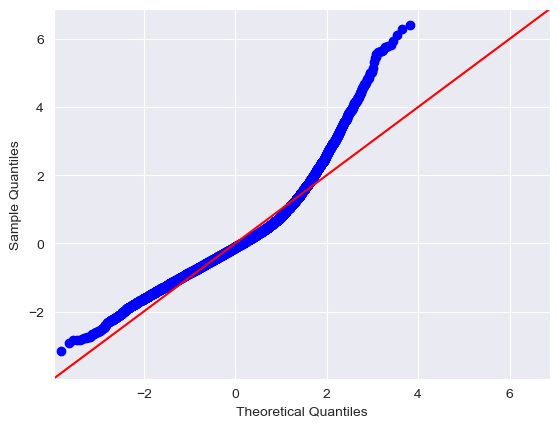

In [169]:
# Check that the residuals are normally distributed
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

### Check Homoscedasticity Assumption

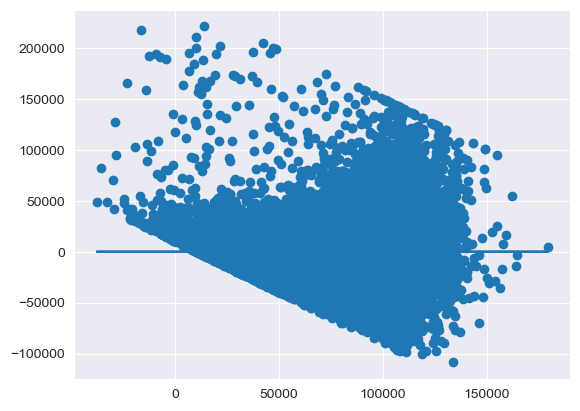

In [171]:
# heck that the residuals are homoscedastic
plt.scatter(model.predict(train[x_keep]), model.resid)
plt.plot(model.predict(train[x_keep]), [0 for i in range(len(train))])

### Additional Refinements To Model

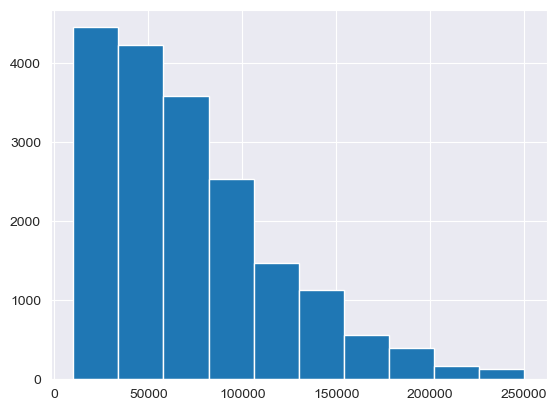

In [173]:
# Check for outliers
df.ConvertedComp.hist()

In [174]:
df.ConvertedComp.sort_values()

50594     10000.0
76849     10000.0
64043     10000.0
49585     10000.0
28701     10019.0
           ...   
80080    250000.0
87930    250000.0
5252     250000.0
16377    250000.0
54013    250000.0
Name: ConvertedComp, Length: 18646, dtype: float64

In [175]:
# Remove extreme outliers
list_first_quartile = []
for i in range(0,20):
    q = i/100
    list_first_quartile.append(df.ConvertedComp.quantile(q=q))
    print("{} percentile: {}".format(q, df.ConvertedComp.quantile(q=q)))
print(f"1st Q: {list_first_quartile[-10]}")
print("")

# Remove extreme outliers
list_fourth_quartile = []
for i in range(80,100):
    q = i/100
    list_fourth_quartile.append(df.ConvertedComp.quantile(q=q))
    print("{} percentile: {}".format(q, df.ConvertedComp.quantile(q=q)))
print(f"4th Q: {list_fourth_quartile[-5]}")

0.0 percentile: 10000.0
0.01 percentile: 10872.0
0.02 percentile: 11520.0
0.03 percentile: 12456.0
0.04 percentile: 13200.0
0.05 percentile: 13993.0
0.06 percentile: 14976.0
0.07 percentile: 16128.0
0.08 percentile: 16884.0
0.09 percentile: 18000.0
0.1 percentile: 19044.0
0.11 percentile: 19998.999999999996
0.12 percentile: 20989.0
0.13 percentile: 21984.0
0.14 percentile: 22944.0
0.15 percentile: 23922.0
0.16 percentile: 25119.200000000004
0.17 percentile: 26157.450000000004
0.18 percentile: 27492.0
0.19 percentile: 28381.400000000012
1st Q: 19044.0

0.8 percentile: 108000.0
0.81 percentile: 110000.0
0.82 percentile: 112277.09999999998
0.83 percentile: 115000.0
0.84 percentile: 119609.99999999997
0.85 percentile: 120000.0
0.86 percentile: 125000.0
0.87 percentile: 127457.79999999999
0.88 percentile: 130000.0
0.89 percentile: 135000.0
0.9 percentile: 140000.0
0.91 percentile: 143000.0
0.92 percentile: 150000.0
0.93 percentile: 150000.0
0.94 percentile: 158600.0
0.95 percentile: 165000.

In [176]:
# Removing Extreme Outliers
orig_tot = len(df)
fourth_quartile = df[df['ConvertedComp'] > list_fourth_quartile[-5]].index
df.drop(fourth_quartile, inplace=True)
# first_quartile = df[df['ConvertedComp'] < list_first_quartile[-1]].index
# df.drop(first_quartile, inplace=True)
print(f'Percent removed: {(orig_tot -len(df))/orig_tot}')
print(f'Rows removed: {(orig_tot -len(df))}')

Percent removed: 0.04816046337015982
Rows removed: 898


### Apply Log Transformation and Re-Run Model

In [177]:
df.ConvertedComp = df.ConvertedComp.map(np.log) # Applying a log transformation
train, test = train_test_split(df)

In [178]:
# Refit model with subset features
predictors = '+'.join(x_keep)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConvertedComp   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     182.2
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:54:22   Log-Likelihood:                -8011.5
No. Observations:               13311   AIC:                         1.624e+04
Df Residuals:                   13204   BIC:                         1.704e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            10.4854      0.041    254.324      0.000      10.405      10.566
WorkWeekHrs                                                                                           0.0063      0.001     12.103      0.000       0.005       0.007
CodeRevHrs                                                                                        -4.773e-05      0.001     -0.046      0.963      -0.002       0.002
learned_code                                                                                         -0.0005      0.001     -0.565      0.572      -0.002       0.001
Bash_Shell_PowerShell                                                                                 0.0665      0.008      8.161      0.000       0.051       0.082
Csharp                                                                                                0.0367      0.009      4.039      0.000       0.019       0.054
Dart                                                                                                 -0.0862      0.028     -3.048      0.002      -0.142      -0.031
Fsharp                                                                                                0.1019      0.035      2.909      0.004       0.033       0.171
Go                                                                                                    0.0871      0.014      6.376      0.000       0.060       0.114
HTML_CSS                                                                                             -0.0481      0.009     -5.465      0.000      -0.065      -0.031
Others                                                                                                0.0080      0.015      0.535      0.593      -0.021       0.037
PHP                                                                                                  -0.1044      0.010    -10.431      0.000      -0.124      -0.085
Ruby                                                                                                  0.0831      0.013      6.305      0.000       0.057       0.109
Scala                                                                                                 0.1038      0.018      5.846      0.000       0.069       0.139
TypeScript                                                                                            0.0252      0.009      2.766      0.006       0.007       0.043
VBA                                                                                            

In [179]:
p_tablee = model.summary().tables[1]
p_tablee = pd.DataFrame(p_tablee.data)
p_tablee.columns = p_tablee.iloc[0]
p_tablee = p_tablee.drop(0)
p_tablee = p_tablee.set_index(p_tablee.columns[0])
p_tablee['P>|t|'] = p_tablee['P>|t|'].astype(float)
p_tablee

,coef,std err,t,P>|t|,[0.025,0.975]
,,,,,,
Intercept,10.4854,0.041,254.324,0.000,10.405,10.566
WorkWeekHrs,0.0063,0.001,12.103,0.000,0.005,0.007
CodeRevHrs,-4.773e-05,0.001,-0.046,0.963,-0.002,0.002
learned_code,-0.0005,0.001,-0.565,0.572,-0.002,0.001
Bash_Shell_PowerShell,0.0665,0.008,8.161,0.000,0.051,0.082
...,...,...,...,...,...,...
SOPartFreq_I_have_never_participated_in_QandA_on_Stack_Overflow,-0.0349,0.010,-3.532,0.000,-0.054,-0.016
Continent_Asia,-0.5964,0.024,-25.142,0.000,-0.643,-0.550
Continent_Oceania_Australia,-0.1034,0.046,-2.230,0.026,-0.194,-0.013


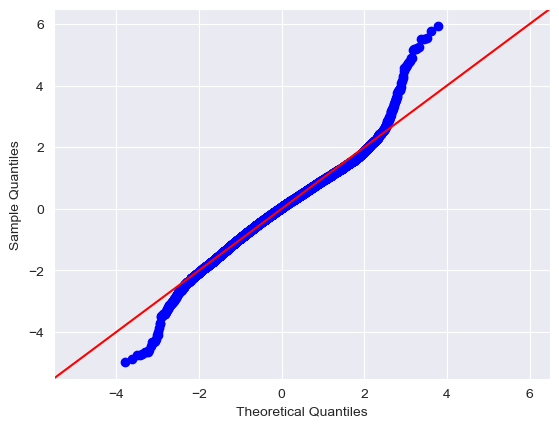

In [180]:
# Check normality assumption
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

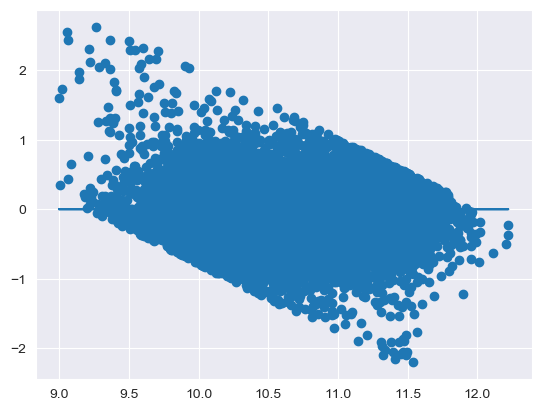

In [181]:
#Check the Homoscedasticity Assumption
plt.scatter(model.predict(train[x_keep]), model.resid)
plt.plot(model.predict(train[x_keep]), [0 for i in range(len(train))])

0.0 percentile: 9.210340371976184
0.01 percentile: 9.290629203204986
0.02 percentile: 9.347664562839402
0.03 percentile: 9.418329675518715
0.04 percentile: 9.48158813796454
0.05 percentile: 9.528939547062684
0.06 percentile: 9.593150789519541
0.07 percentile: 9.662368163875502
0.08 percentile: 9.719778317203755
0.09 percentile: 9.772624555061117
0.1 percentile: 9.817079584856284
0.11 percentile: 9.877658818096801
0.12 percentile: 9.93440465517085
0.13 percentile: 9.967025573340116
0.14 percentile: 10.00946787607336
0.15 percentile: 10.047094261788464
0.16 percentile: 10.087807111992756
0.17 percentile: 10.134599273499514
0.18 percentile: 10.178388290623175
0.19 percentile: 10.221650332241495


9.817079584856284

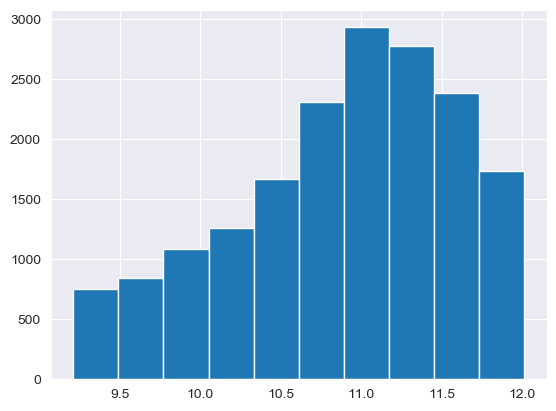

In [182]:
list_first_quartile_log = []
for i in range(0,20):
    q = i/100
    list_first_quartile_log.append(df.ConvertedComp.quantile(q=q))
    print("{} percentile: {}".format(q, df.ConvertedComp.quantile(q=q)))

df.ConvertedComp.hist()
list_first_quartile_log[-10]

0.8 percentile: 11.512925464970229
0.81 percentile: 11.51754477949005
0.82 percentile: 11.543619544870252
0.83 percentile: 11.56171562913966
0.84 percentile: 11.589886506106357
0.85 percentile: 11.608235644774552
0.86 percentile: 11.626254150277232
0.87 percentile: 11.652687407345388
0.88 percentile: 11.678439903447801
0.89 percentile: 11.695247021764185
0.9 percentile: 11.720957378899334
0.91 percentile: 11.736105975397427
0.92 percentile: 11.77528972943772
0.93 percentile: 11.797901554318484
0.94 percentile: 11.825351664784304
0.95 percentile: 11.84939770159144
0.96 percentile: 11.884489021402711
0.97 percentile: 11.918390573078392
0.98 percentile: 11.938193200374572
0.99 percentile: 11.982929094215963


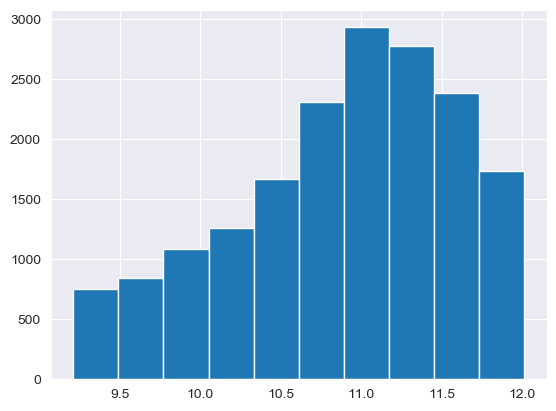

In [183]:
for i in range(80,100):
    q = i/100
    print("{} percentile: {}".format(q, df.ConvertedComp.quantile(q=q)))

df.ConvertedComp.hist()

In [184]:
# df = df[df.ConvertedComp <= 11]
log_transformation = df[df['ConvertedComp'] < list_first_quartile_log[-10]].index
df.drop(log_transformation, inplace=True)

train, test = train_test_split(df)

# Refit model with subset features
predictors = '+'.join(x_keep)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ConvertedComp   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     110.6
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        18:54:28   Log-Likelihood:                -5764.5
No. Observations:               11979   AIC:                         1.174e+04
Df Residuals:                   11872   BIC:                         1.253e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================================
                                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            10.6479      0.041    262.069      0.000      10.568      10.728
WorkWeekHrs                                                                                           0.0064      0.001     12.026      0.000       0.005       0.007
CodeRevHrs                                                                                         -7.77e-05      0.001     -0.079      0.937      -0.002       0.002
learned_code                                                                                         -0.0011      0.001     -1.322      0.186      -0.003       0.001
Bash_Shell_PowerShell                                                                                 0.0531      0.008      7.053      0.000       0.038       0.068
Csharp                                                                                                0.0230      0.009      2.693      0.007       0.006       0.040
Dart                                                                                                 -0.0337      0.028     -1.215      0.225      -0.088       0.021
Fsharp                                                                                                0.1182      0.033      3.572      0.000       0.053       0.183
Go                                                                                                    0.0768      0.012      6.227      0.000       0.053       0.101
HTML_CSS                                                                                             -0.0417      0.008     -5.110      0.000      -0.058      -0.026
Others                                                                                                0.0236      0.014      1.718      0.086      -0.003       0.051
PHP                                                                                                  -0.1029      0.010    -10.807      0.000      -0.122      -0.084
Ruby                                                                                                  0.0713      0.012      5.938      0.000       0.048       0.095
Scala                                                                                                 0.0786      0.016      4.868      0.000       0.047       0.110
TypeScript                                                                                            0.0255      0.009      2.996      0.003       0.009       0.042
VBA                                                                                            

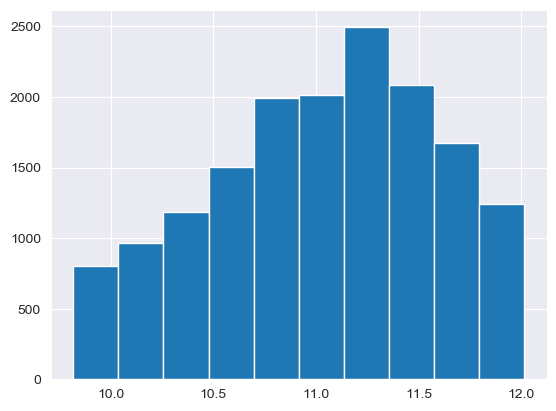

In [185]:
df.ConvertedComp.hist()

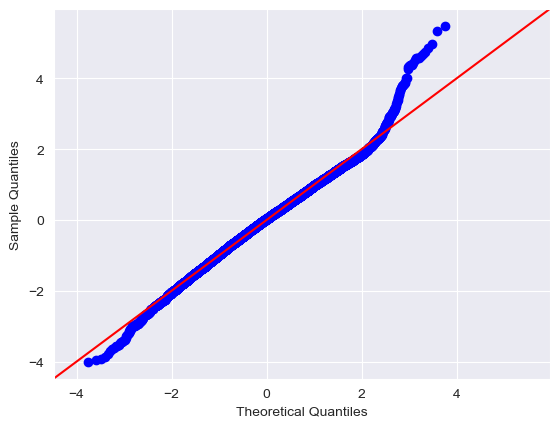

In [186]:
# Check the Normality Assumption
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

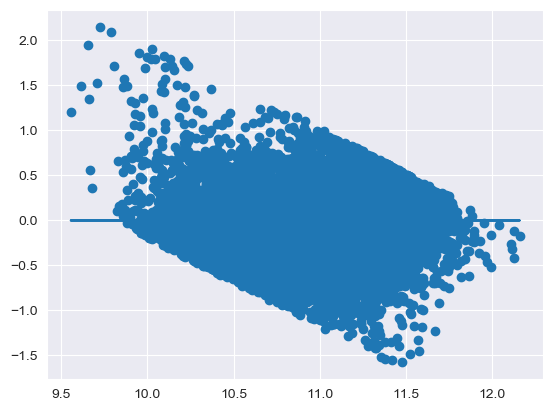

In [187]:
plt.scatter(model.predict(train[x_keep]), model.resid)
plt.plot(model.predict(train[x_keep]), [0 for i in range(len(train))])

In [189]:
# len(x_keep)
# x_keep

### Playing With Charlie Function

In [ ]:
X = df.drop(columns=['Respondent','ConvertedComp'])
Y = df['ConvertedComp']

sm_performance,sm_variables,sm_outcomes = sm_OLS(X,Y)

# make a deep copy of our X values for the recursive function
X_recursive = pd.DataFrame.copy(X,deep=True)

# recursive_performance,recursive_variables,recursive_outcomes = ols_recursion(X_recursive,Y)

comparison = pd.concat((sm_performance.transpose(),recursive_performance.transpose()),ignore_index=True)
comparison.index = ['294 predictors','118 predictors']
# comparison

# X_recursive

subs = [(' ', '_'), ('.', ''), ("’", ""), ("'", ""),
        (';', '_'), ('/', '_'), ('(', ''), (')', ''),
        (':', ''), ('-', '_'), (',', '_'), 
        ('___', '_'), ('__', '_'),
        ('#', 'sharp'), ('+', 'plus'), ('&', 'and')
        ]

def col_formatting(col):
    for old, new in subs:
        col = col.replace(old,new)
    return col

X_recursive.columns = [col_formatting(col) for col in X_recursive.columns]

# list(X_recursive.columns)

x_cols = list(X_recursive.columns)

### Scratch Work

In [ ]:
# generate random data-set
np.random.seed(0)
x = df[['Respondent']]
y = df[['ConvertedComp']]

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(x, y)
# Predict
y_predicted = regression_model.predict(x)

# model evaluation
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)

# plotting values

# data points
# plt.scatter(x, y, s=10)
# plt.xlabel(x.columns[0])
# plt.ylabel(y.columns[0])

# predicted values
# plt.plot(x, y_predicted, color='r')
# plt.show()

In [5]:
df_gender_man = pd.DataFrame(df[['ConvertedComp', 'Gender_Man']])
is_not_man = df_gender_man[df_gender_man['Gender_Man'] == 0].index
df_gender_man.drop(is_not_man, inplace=True)

In [6]:
df_gender_man.describe()

,ConvertedComp,Gender_Man
count,17380.000000,17380.0
mean,71574.467491,1.0
std,47489.021562,0.0
min,10000.000000,1.0
25%,34560.000000,1.0
50%,61870.000000,1.0
75%,97389.000000,1.0
max,250000.000000,1.0


In [7]:
df_gender_woman = pd.DataFrame(df[['ConvertedComp', 'Gender_Woman']])
is_not_woman = df_gender_woman[df_gender_woman['Gender_Woman'] == 0].index
df_gender_woman.drop(is_not_woman, inplace=True)

In [8]:
df_gender_woman.describe()

,ConvertedComp,Gender_Woman
count,1123.000000,1123.0
mean,71851.804987,1.0
std,44217.543165,0.0
min,10080.000000,1.0
25%,38583.500000,1.0
50%,64162.000000,1.0
75%,99595.000000,1.0
max,250000.000000,1.0


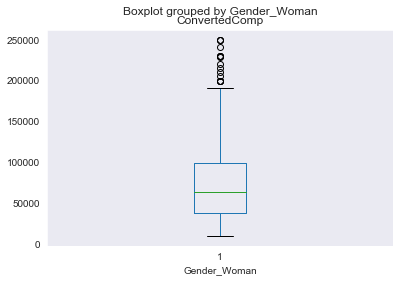

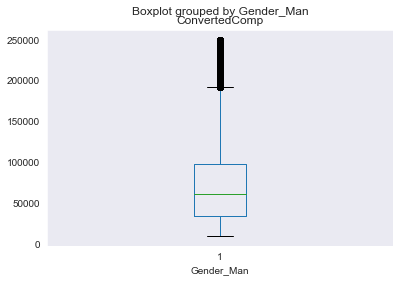

In [25]:
df_gender_woman.boxplot(by ='Gender_Woman', column =['ConvertedComp'], grid = False)
df_gender_man.boxplot(by ='Gender_Man', column =['ConvertedComp'], grid = False)

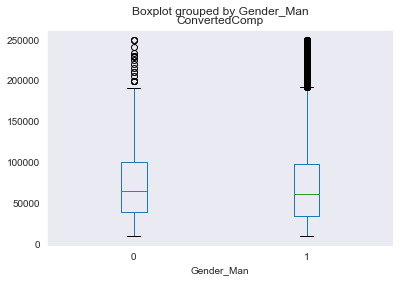

In [13]:
df.boxplot(by ='Gender_Man', column =['ConvertedComp'], grid = False)

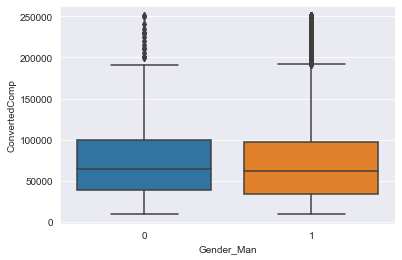

In [21]:
sns.boxplot(x = 'Gender_Man', y = 'ConvertedComp', data = df) 

In [122]:
continents = [x for x in df.columns.tolist() if 'Continent' in x]
continents

dfs = []
for continent in continents:
    temp = df.groupby(continent).mean().iloc[[1]]
    temp.index = [continent]
    dfs.append(temp)
df_continents = pd.concat(dfs,sort=False)


In [141]:
df_continents_converted_comp = pd.DataFrame(df_continents['ConvertedComp']).sort_values(by=['ConvertedComp'], ascending=False)

list_continents = [x for x in df_continents_converted_comp.index.tolist()]
list_removed_continents_prefix = [x.replace("Continent_","") for x in list_continents]
# df_continents_converted_comp.reset_index(level=0, inplace=True)

In [142]:
list_continents

['Continent_North America',
 'Continent_Oceania Australia',
 'Continent_Europe',
 'Continent_Asia',
 'Continent_Africa',
 'Continent_South America']

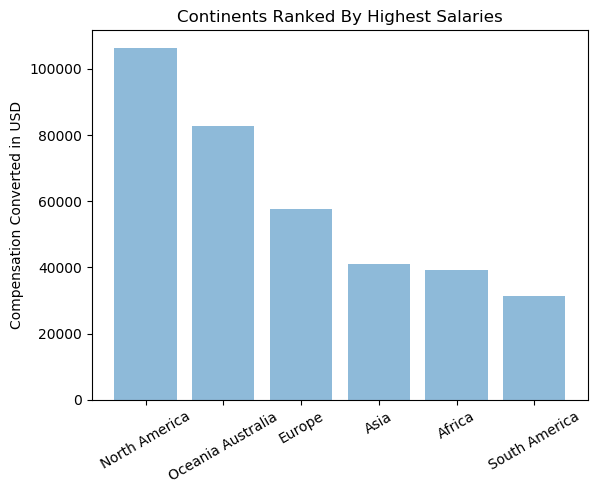

In [144]:
list_continents = list_removed_continents_prefix
list_converted_comp = [x for x in df_continents_converted_comp['ConvertedComp']]
# ax = sns.countplot(x = continents['index'], data=continents['ConvertedComp'])

plt.bar(list_continents, list_converted_comp, align='center', alpha=0.5)
plt.xticks(list_continents, rotation=30)
plt.ylabel('Compensation Converted in USD')
plt.title('Continents Ranked By Highest Salaries')

plt.show()

In [117]:
list_continents

['Africa',
 'Asia',
 'Europe',
 'North America',
 'Oceania Australia',
 'South America']

In [90]:
np.arange(len(objects))

array([0, 1, 2, 3, 4, 5])

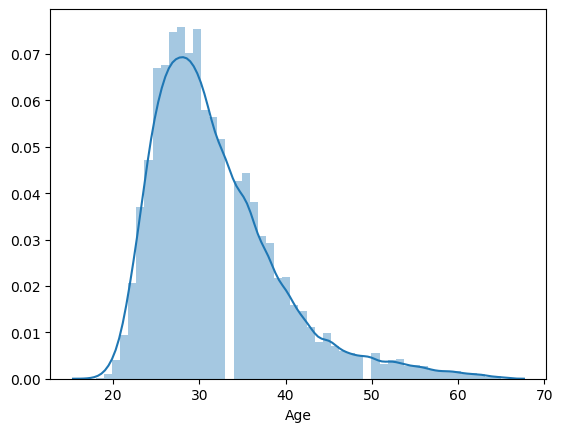

In [147]:
sns.distplot(df['Age'], kde=True)

In [ ]:
# scratch work

# df[df['ConvertedComp'] < 2000].sort_values('ConvertedComp', ascending=True)
# df_cleaned[df_cleaned['ConvertedComp'] > 490000].sort_values('ConvertedComp', ascending=True)
# list(df.columns)
# len(list(df.columns))
# corr = df.corr()
# fig, ax = plt.subplots(figsize=(10,10))

# ax = sns.heatmap(
#     corr,
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

# df[df['ConvertedComp'] == 0].sort_values('ConvertedComp', ascending=True)

# cleaned_df = df[['Respondent','ConvertedComp',
#                  'YearsCode','Age','WorkWeekHrs']].dropna()

# df_test = cleaned_df.groupby('Gender')['Respondent'].nunique()
# df_test

# cleaned_df[cleaned_df['ConvertedComp'] >= 1000000].sort_values('Age', ascending=True)
# df_converted_comp = pd.DataFrame(cleaned_df[['Respondent', 'YearsCode', 'Age']])
# troll = df_converted_comp[ (df_converted_comp['YearsCode'] < 10) ].index

# cleaned_df['ConvertedComp'].describe()
# test = cleaned_df.sort_values('Age', ascending=True)[:650]
# test
# cleaned_df[(cleaned_df['Age'] < 18)].sort_values('Age')
# cleaned_df[(cleaned_df['Age'] < 18)].sort_values('Age').describe()
# list_of_unique_countries = cleaned_df['Country'].unique()

# list_of_unique_continent = cleaned_df['Continent'].unique()
# foo = cleaned_df[ cleaned_df['Respondent'] == 1438 ]
# foo = cleaned_df.sort_values('WorkWeekHrs', ascending=False)
# foo
# foo.describe()
# df_test = cleaned_df.groupby('WorkWeekHrs')['Respondent'].nunique()
# df_test
# x = np.random.rand(100, 1)
# y = 2 + 3 * x + np.random.rand(100, 1)
# x = cleaned_df.drop(columns=['ConvertedComp'])
# x = cleaned_df[cleaned_df['calc_age'] > 18]
# y = cleaned_df[(cleaned_df['calc_age'] > 18) & (cleaned_df['ConvertedComp'])]

### barchart plt
# continents = [x for x in df.columns.tolist() if 'Continent' in x]

# dfs = []
# for continent in continents:
#     temp = df.groupby(continent).mean().iloc[[1]]
#     temp.index = [continent]
#     dfs.append(temp)
# df_continents = pd.concat(dfs,sort=False)

# df_continents_converted_comp = pd.DataFrame(df_continents['ConvertedComp']).sort_values(by=['ConvertedComp'], ascending=False)

# list_continents = [x for x in df_continents_converted_comp.index.tolist()]
# list_removed_continents_prefix = [x.replace("Continent_","") for x in list_continents]

# list_continents = list_removed_continents_prefix
# list_converted_comp = [x for x in df_continents_converted_comp['ConvertedComp']]

# plt.bar(list_continents, list_converted_comp, align='center', alpha=0.5)
# plt.xticks(list_continents, rotation=30)
# plt.ylabel('Compensation Converted in USD')
# plt.title('Continents Ranked By Highest Mean Salaries')

# plt.show()